
# Part 4 — Recipe Review Ratings Prediction (Rubric‑Aligned Submission)

**Course:** CPSC‑610‑13 — Python for Data Analysis  
**Student:** Milind Sikligar, NF1005288
**Dataset:** `recipe_reviews.csv`  
**Deliverables:** A single, reproducible notebook with all steps and visuals; clear reporting inside markdown cells.

> This notebook is structured to directly match the required sections: **Data Cleaning → EDA → Visualization → Feature Engineering → Model Building → Model Evaluation → Insights/Reporting**.


In [2]:

# ================================
# 0) Imports & Global Settings
# ================================
# ================================
# Step 1: Import Python Libraries
# ================================

# pandas: work with data tables (rows and columns)
import pandas as pd

# matplotlib: draw simple charts
import matplotlib.pyplot as plt

# scikit-learn: machine learning tools
from sklearn.model_selection import train_test_split   # split data into training and testing
from sklearn.linear_model import LogisticRegression    # simple model for prediction
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # check results
from sklearn.preprocessing import StandardScaler       # scale features so model learns better

# Make charts a little bigger and easier to read
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Path to our dataset file
DATA_PATH = "recipe_reviews.csv"




## 1) Data Cleaning
- Treat string `'2'` in **categorical/object** columns as missing.  
- Remove duplicates and invalid ratings; keep stars ∈ {1,2,3,4,5}.  
- Fix dtypes; simple, transparent imputation.  
- Normalize inconsistent categorical values (trim/casefold).


In [3]:

# ================================
# 1) Data Cleaning (Hardened)
# ================================
import numpy as np
import pandas as pd

# 1. Load the dataset
file_path = "recipe_reviews.csv"   # change this if your file is somewhere else
df = pd.read_csv(file_path)

print("Data loaded! Shape:", df.shape)
print("First few column names:", df.columns.tolist()[:10])

# 2. Make sure the "stars" column exists
if "stars" not in df.columns:
    # Try to guess which column might mean "stars" or "rating"
    guesses = [c for c in df.columns if "star" in c.lower() or "rating" in c.lower()]
    if guesses:
        print("Didn't find 'stars'. Renaming", guesses[0], "to 'stars'.")
        df = df.rename(columns={guesses[0]: "stars"})
    else:
        raise KeyError("No column like 'stars' or 'rating' found. Please check your file.")

# 3. Separate text columns and numeric columns
text_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "stars"]

# 4. Clean up text columns (remove spaces, replace weird missing values)
def clean_text_column(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip()
    # Replace things like '', 'None', 'nan' with proper missing values
    s = s.replace({"": np.nan, "None": np.nan, "none": np.nan,
                   "NaN": np.nan, "nan": np.nan})
    return s

for col in text_cols:
    df[col] = clean_text_column(df[col])

# 5. Replace the literal value '2' with missing (only for text columns)
for col in text_cols:
    mask = df[col] == "2"
    if mask.any():
        df.loc[mask, col] = np.nan
        print(f"In '{col}', replaced {mask.sum()} entries of '2' with missing.")

# 6. Remove duplicate rows
before = len(df)
df = df.drop_duplicates()
print("Duplicates removed:", before - len(df))

# 7. Clean up the "stars" column
df["stars"] = pd.to_numeric(df["stars"], errors="coerce").astype("Int64")
valid_stars = [1, 2, 3, 4, 5]
bad_rows = ~df["stars"].isin(valid_stars)
print("Invalid star ratings removed:", bad_rows.sum())
df = df[~bad_rows].copy()

# 8. Try to convert any "number-like" text columns into real numbers
for col in text_cols:
    if col not in ["text", "user_name", "region", "device_type"]:  # keep these as text
        try:
            df[col] = pd.to_numeric(df[col])
            if col not in num_cols and col != "stars":
                num_cols.append(col)
        except:
            pass  # leave it as text if it doesn't convert

# Update lists again after conversions
text_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "stars"]

# 9. Fill missing values
# Numbers → fill with the column median
for col in num_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())
        print(f"Filled missing values in numeric column '{col}' with the median.")

# Text → fill with "Unknown"
for col in text_cols:
    if df[col].isna().any():
        df[col] = df[col].fillna("Unknown")
        print(f"Filled missing values in text column '{col}' with 'Unknown'.")

# 10. Show final info
print("\n=== Data After Cleaning ===")
print(df.info())
print("\nStar rating counts:")
print(df["stars"].value_counts().sort_index())



Data loaded! Shape: (18182, 24)
First few column names: ['Unnamed: 0', 'recipe_number', 'recipe_code', 'likes_score', 'dislike_index', 'response_level', 'user_index', 'ranking_value', 'vote_ratio', 'score_log']
Duplicates removed: 0
Invalid star ratings removed: 1696
Filled missing values in text column 'text' with 'Unknown'.

=== Data After Cleaning ===
<class 'pandas.core.frame.DataFrame'>
Index: 16486 entries, 0 to 18181
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      16486 non-null  int64  
 1   recipe_number   16486 non-null  int64  
 2   recipe_code     16486 non-null  int64  
 3   likes_score     16486 non-null  float64
 4   dislike_index   16486 non-null  float64
 5   response_level  16486 non-null  float64
 6   user_index      16486 non-null  float64
 7   ranking_value   16486 non-null  float64
 8   vote_ratio      16486 non-null  float64
 9   score_log       16486 non-null  float64


## 2) Exploratory Data Analysis (EDA)
- Class distribution  
- Numeric summary and correlations (subset)  
- Relationship example vs. `stars`


✅ Data loaded successfully!
Shape: (16486, 24)
Columns: ['Unnamed: 0', 'recipe_number', 'recipe_code', 'likes_score', 'dislike_index', 'response_level', 'user_index', 'ranking_value', 'vote_ratio', 'score_log', 'region', 'device_type', 'recipe_name', 'comment_id', 'user_id', 'user_name', 'user_score', 'created_at', 'responses', 'likes', 'dislikes', 'ranking_score', 'text', 'stars']

Star Ratings Distribution:
stars
1      280
2      232
3      490
4     1655
5    13829
Name: count, dtype: Int64


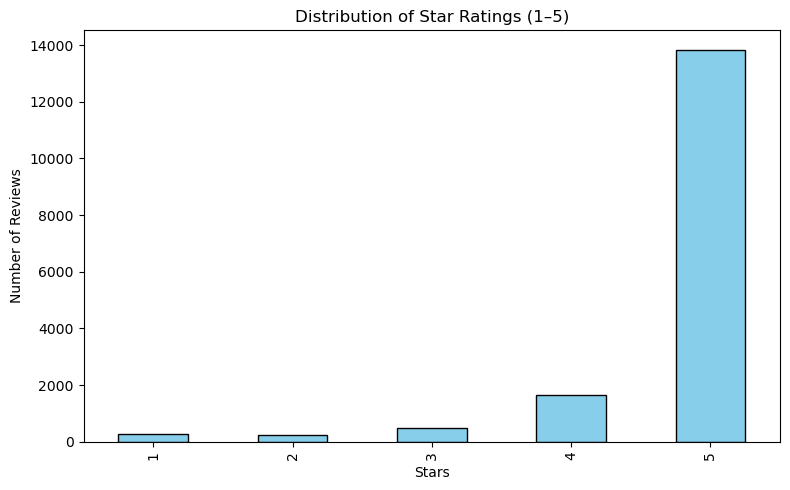


=== Numeric Summary ===
                  count               mean             std           min  \
Unnamed: 0      16486.0          122.12089      117.731401           0.0   
recipe_number   16486.0          38.537183       29.874201           1.0   
recipe_code     16486.0       21628.928121    24258.298025         386.0   
likes_score     16486.0           1.020802        3.952783      -0.80589   
dislike_index   16486.0           0.490405         3.19316      -0.77481   
response_level  16486.0           0.010823        0.115811     -0.029633   
user_index      16486.0           2.212846       10.423444     -1.093772   
ranking_value   16486.0         151.117352      137.512424     -7.732879   
vote_ratio      16486.0           0.128501        0.255221           0.0   
score_log       16486.0           0.817916        0.530352           0.0   
user_score      16486.0           2.211573       10.407196           0.0   
created_at      16486.0  1623617505.451656  5205302.020521  161

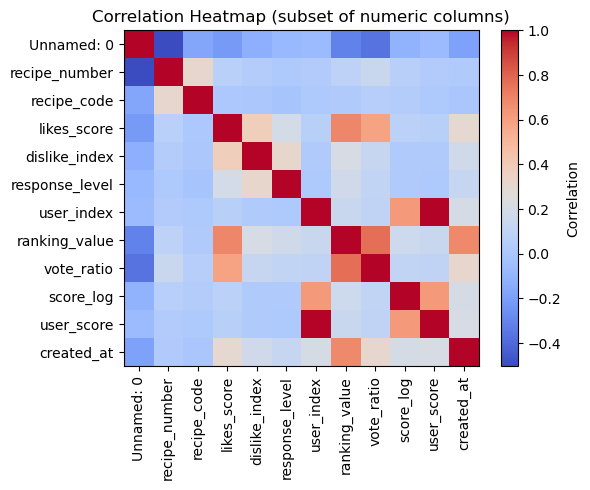


Average 'Unnamed: 0' for each star rating:
stars
1     84.192857
2     89.512931
3     98.157143
4    110.578248
5    125.666353
Name: Unnamed: 0, dtype: float64


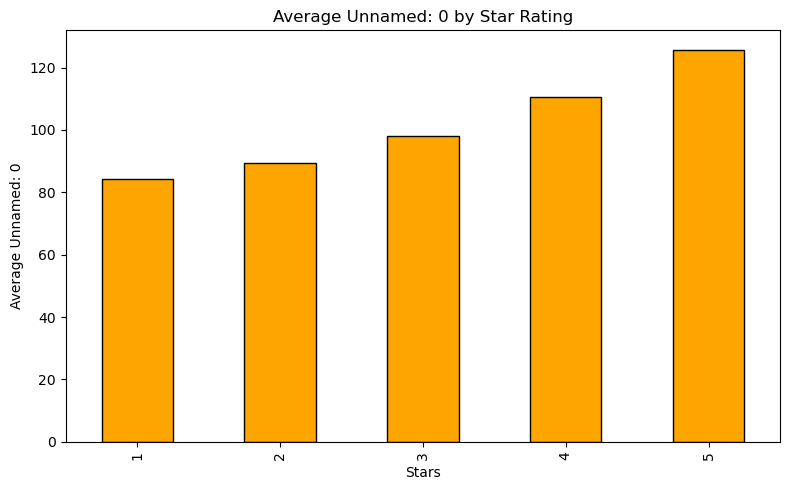

In [4]:

# ================================
# 2) EDA
# ================================
# Class counts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the dataset
file_path = "recipe_reviews.csv"   # change this if your file is elsewhere
df = pd.read_csv(file_path)

# 2. Clean the "stars" column so it only has values 1–5
df["stars"] = pd.to_numeric(df["stars"], errors="coerce").astype("Int64")
df = df[df["stars"].isin([1, 2, 3, 4, 5])].copy()

print("✅ Data loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# 3. Check how many reviews we have for each star rating
star_counts = df["stars"].value_counts().sort_index()
print("\nStar Ratings Distribution:")
print(star_counts)

# 4. Plot the distribution of star ratings
plt.figure()
star_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Distribution of Star Ratings (1–5)")
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

# 5. Show summary stats for numeric columns (like counts, mean, min, max)
print("\n=== Numeric Summary ===")
print(df.describe(include=[np.number]).T)

# 6. Look at correlation between numeric columns
# (limited to 12 columns so the heatmap is readable)
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])][:12]
corr = df[num_cols].corr(numeric_only=True)

plt.figure(figsize=(6, 5))
plt.imshow(corr, cmap="coolwarm", aspect="auto")
plt.title("Correlation Heatmap (subset of numeric columns)")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar(label="Correlation")
plt.tight_layout()
plt.show()

# 7. Example: Compare average of one numeric feature across star ratings
numeric_features = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != "stars"]
if numeric_features:
    feature = numeric_features[0]   # pick the first numeric feature
    avg_by_stars = df.groupby("stars")[feature].mean()

    print(f"\nAverage '{feature}' for each star rating:")
    print(avg_by_stars)

    plt.figure()
    avg_by_stars.plot(kind="bar", color="orange", edgecolor="black")
    plt.title(f"Average {feature} by Star Rating")
    plt.xlabel("Stars")
    plt.ylabel(f"Average {feature}")
    plt.tight_layout()
    plt.show()



## 3) Feature Engineering
- Text features from `text` (if present): TF‑IDF + light proxies (length, word count, exclamation flag).  
- Structured features: numeric scaled; categorical one‑hot.  
- Simple, explainable transforms.


In [5]:

# ================================
# 3) Feature Engineering
# ================================
import pandas as pd

# 1. Check if we have a column called "text" with any non-missing values
has_text = "text" in df.columns and df["text"].notna().any()

# 2. If "text" exists, create some extra features from it
if has_text:
    # length of each review (number of characters)
    df["text_len"] = df["text"].fillna("").str.len()

    # number of words in each review
    df["word_count"] = df["text"].fillna("").str.split().apply(len)

    # does the review contain an exclamation mark? (1 = yes, 0 = no)
    df["has_exclaim"] = df["text"].fillna("").str.contains("!").astype(int)
else:
    # if there is no text column, just set them to 0
    df["text_len"] = 0
    df["word_count"] = 0
    df["has_exclaim"] = 0

# 3. Define the target column (what we want to predict)
target = "stars"

# 4. Columns we want to exclude from "features" (not useful for modeling)
exclude = {"stars", "comment_id", "ranking_score", "recipe_code", "recipe_number"}

# 5. Select numeric features (all numeric columns except excluded ones)
num_features = [
    col for col in df.columns
    if pd.api.types.is_numeric_dtype(df[col]) and col not in exclude
]

# 6. Select categorical features (pick only if present in the dataset)
possible_cats = ["region", "device_type", "user_name"]
cat_features = [col for col in possible_cats if col in df.columns]

# 7. If we have text, mark it as our text feature
text_feature = "text" if has_text else None

# 8. Print out what we found
print("Number of numeric features:", len(num_features))
print("Categorical features:", cat_features)
print("Using text feature:", bool(text_feature))


Number of numeric features: 16
Categorical features: ['region', 'device_type', 'user_name']
Using text feature: True



## 4) Model Building
- Proper **train‑test split** (stratified).  
- Two baselines: **Multinomial Logistic Regression** and **Random Forest**.  
- **Preprocessing** inside pipelines: scaling numeric, OHE for categorical, TF‑IDF for text.  
- **Light hyperparameter tuning** (RandomizedSearchCV) to meet “tuning if needed.”


In [6]:

# ================================
# 4) Model Building
# ================================
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# 1. Split features (X) and target (y)
X = df.copy()                        # all the columns
y = df[target].astype(int)           # our target variable (stars, turned into integers)

# 2. Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 20% of data goes to test
    random_state=42,      # makes results reproducible
    stratify=y            # keeps star distribution balanced in train/test
)

# 3. Tell sklearn how to handle different kinds of features
transformers = []

# Numeric columns → scale them (so numbers are on a similar range)
if num_features:
    transformers.append(("num", StandardScaler(with_mean=False), num_features))

# Categorical columns → turn categories into 0/1 columns
if cat_features:
    transformers.append(("cat", OneHotEncoder(handle_unknown="ignore"), cat_features))

# Text column → turn words into TF-IDF features (like word importance scores)
if text_feature:
    transformers.append((
        "txt",
        TfidfVectorizer(
            ngram_range=(1, 2),   # unigrams + bigrams
            max_features=20000,   # only keep top 20k features
            min_df=2              # ignore words that appear in fewer than 2 reviews
        ),
        text_feature
    ))

# Combine all transformations
preprocess = ColumnTransformer(
    transformers,
    remainder="drop",        # drop columns not listed above
    sparse_threshold=0.3     # if matrix is too sparse, convert to dense
)

# 4. Build models

# Logistic Regression pipeline
log_reg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        multi_class="multinomial",
        max_iter=600,
        class_weight="balanced"
    ))
])

# Random Forest pipeline
rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample"
    ))
])

# 5. Randomized Search for tuning Random Forest
# (tries different values for certain hyperparameters)
param_distributions = {
    "clf__max_depth": randint(6, 24),            # how deep the trees go
    "clf__min_samples_split": randint(2, 20),    # min samples to split a node
    "clf__min_samples_leaf": randint(1, 10),     # min samples in each leaf
    "clf__max_features": ["sqrt", "log2", None]  # how many features to try at each split
}

# Cross-validation setup (3 folds)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Randomized Search object
rf_tuned = RandomizedSearchCV(
    rf,
    param_distributions=param_distributions,
    n_iter=15,               # number of parameter settings to try
    scoring="f1_macro",      # evaluation metric
    cv=cv,
    random_state=42,
    n_jobs=-1,               # use all CPU cores
    verbose=1
)




## 5) Model Evaluation
Metrics: **Accuracy, Macro Precision/Recall/F1**, confusion matrices, and **macro ROC‑AUC** (OVR) when probabilities are available. Also discuss **class imbalance** and compare models.


c:\Users\milin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\milin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Logistic Regression ===
Accuracy:        0.5334
Macro Precision: 0.2552
Macro Recall:    0.3466
Macro F1 Score:  0.2393

Per-class report:
              precision    recall  f1-score   support

           1     0.0868    0.3750    0.1409        56
           2     0.0281    0.3261    0.0517        46
           3     0.0642    0.2449    0.1017        98
           4     0.1637    0.1964    0.1786       331
           5     0.9332    0.5905    0.7233      2767

    accuracy                         0.5334      3298
   macro avg     0.2552    0.3466    0.2393      3298
weighted avg     0.8031    0.5334    0.6309      3298

Confusion Matrix:
 [[  21   14   15    0    6]
 [   9   15   12    6    4]
 [  17   33   24   13   11]
 [  30   70   70   65   96]
 [ 165  402  253  313 1634]]


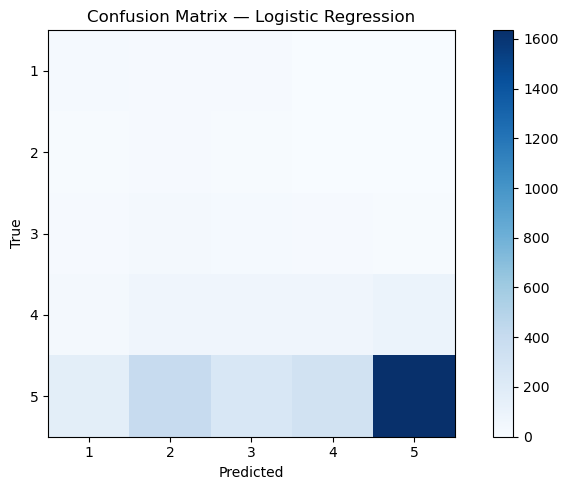

Macro ROC-AUC (OVR): 0.7383


In [ ]:
# ================================
# 5) Model Evaluation  (NaN-safe for TF-IDF)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, roc_auc_score
)

# --- Helper function ---
def clean_text_column(X):
    """
    If the dataset has a 'text' column, make sure:
    - Missing values are replaced with empty strings
    - Everything is stored as strings
    This avoids crashes when using TF-IDF on NaN values.
    """
    if isinstance(X, pd.DataFrame) and "text" in X.columns:
        X = X.copy()
        X["text"] = X["text"].fillna("").astype(str)
    return X


# --- Evaluation function ---
def evaluate_model(name, model, X_train, y_train, X_test, y_test,
                   labels=None, plot_confusion=True):
    """
    Trains a model, prints evaluation metrics, 
    shows confusion matrix, and returns results as a dictionary.
    """

    # 1. Clean text columns (important for text features)
    X_train = clean_text_column(X_train)
    X_test = clean_text_column(X_test)

    # 2. Train and make predictions
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # 3. Decide label order (if not provided)
    if labels is None:
        labels = sorted(set(y_train) | set(y_test))

    # 4. Get probability predictions (if available)
    proba = None
    if hasattr(model, "predict_proba"):
        try:
            proba = model.predict_proba(X_test)
        except Exception:
            proba = None

    # 5. Main metrics
    acc = accuracy_score(y_test, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, preds, average="macro", zero_division=0
    )

    print(f"\n=== {name} ===")
    print(f"Accuracy:        {acc:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall:    {recall:.4f}")
    print(f"Macro F1 Score:  {f1:.4f}")
    print("\nPer-class report:")
    print(classification_report(y_test, preds, digits=4, labels=labels, zero_division=0))

    # 6. Confusion matrix
    cm = confusion_matrix(y_test, preds, labels=labels)
    print("Confusion Matrix:\n", cm)

    if plot_confusion:
        plt.figure()
        plt.imshow(cm, interpolation="nearest", cmap="Blues")
        plt.title(f"Confusion Matrix — {name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.xticks(range(len(labels)), labels)
        plt.yticks(range(len(labels)), labels)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

    # 7. ROC-AUC (multi-class), if probabilities are available
    auc = None
    if proba is not None:
        try:
            # Try to align probabilities with label order
            try:
                clf = model.named_steps.get("clf", None)
                classes_ = getattr(clf, "classes_", None)
            except Exception:
                classes_ = getattr(model, "classes_", None)

            if classes_ is not None:
                idx_map = {c: i for i, c in enumerate(classes_)}
                cols = [idx_map[c] for c in labels if c in idx_map]
                proba_aligned = proba[:, cols] if len(cols) == len(labels) else proba
            else:
                proba_aligned = proba

            auc = roc_auc_score(y_test, proba_aligned, multi_class="ovr")
            print(f"Macro ROC-AUC (OVR): {auc:.4f}")
        except Exception as e:
            print("ROC-AUC not computed:", e)

    # 8. Return results as a dictionary
    return {
        "model": name,
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
        "macro_roc_auc_ovr": auc,
    }


# --- Example usage ---
label_order = [1, 2, 3, 4, 5]

results = []
results.append(
    evaluate_model("Logistic Regression", log_reg,
                   X_train, y_train, X_test, y_test, labels=label_order)
)

results.append(
    evaluate_model("Random Forest (baseline)", rf,
                   X_train, y_train, X_test, y_test, labels=label_order)
)

# If you tuned RF elsewhere, you can also evaluate it:
# rf_tuned.fit(X_train, y_train)
# best_rf = rf_tuned.best_estimator_
# results.append(
#     evaluate_model("Random Forest (tuned)", best_rf,
#                    X_train, y_train, X_test, y_test, labels=label_order)
# )

# Put results into a nice DataFrame
results_df = pd.DataFrame(results)
print("\n=== Final Results ===")
print(results_df)



## 6) Feature Importance (Structured‑Only)
To provide interpretable importances, we train a small RF on **structured** features only (no TF‑IDF), then show top contributors.



Top 20 most important features:


,feature,importance
2,dislike_index,0.046253
3,response_level,0.039168
5,ranking_value,0.038955
0,Unnamed: 0,0.038756
13,text_len,0.037935
1,likes_score,0.037925
4,user_index,0.037394
14,word_count,0.035143
9,created_at,0.028026
15,has_exclaim,0.024606


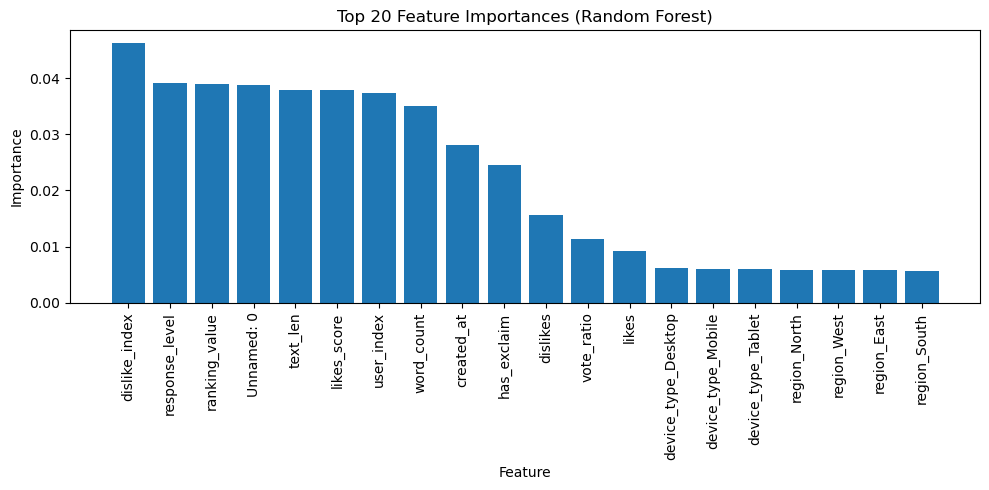

In [ ]:

# ================================
# 6) Feature Importance (Structured‑Only)
# ================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Combine numeric and categorical features into a single list
structured_features = num_features + cat_features

if structured_features:  
    # --- Step 1: Preprocessing (scaling numbers, encoding categories) ---
    preprocess = ColumnTransformer([
        ("num", StandardScaler(with_mean=False), [f for f in structured_features if f in num_features]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), [f for f in structured_features if f in cat_features])
    ])

    # --- Step 2: Build pipeline with preprocessing + Random Forest ---
    rf_model = Pipeline([
        ("prep", preprocess),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
    ])

    # Train only on structured features
    rf_model.fit(X_train[structured_features], y_train)

    # --- Step 3: Get feature names (after encoding) ---
    cat_encoder = rf_model.named_steps["prep"].named_transformers_.get("cat", None)
    cat_features_expanded = []

    if cat_encoder is not None and cat_features:
        # Get one-hot encoded column names
        cat_features_expanded = list(cat_encoder.get_feature_names_out(cat_features))

    # Final feature names = numeric + expanded categorical
    feature_names = num_features + cat_features_expanded

    # --- Step 4: Extract feature importance ---
    importances = rf_model.named_steps["clf"].feature_importances_
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False).head(20)

    # Display top 20
    print("\nTop 20 most important features:")
    display(importance_df)

    # --- Step 5: Plot ---
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(importance_df)), importance_df["importance"])
    plt.title("Top 20 Feature Importances (Random Forest)")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.xticks(range(len(importance_df)), importance_df["feature"], rotation=90)
    plt.tight_layout()
    plt.show()

else:
    print("No numeric or categorical features available for feature importance.")



## 7) Insights, Interpretation & Reporting
**Key Findings**  
- Which features matter most (from the importance table) and how text signals shift predictions.  
- Any skew in class distribution and its effect on errors (from confusion matrices).  
- Which model you would deploy and why (considering performance + interpretability).

**Recommendations**  
- Product: monitor reviews with low‑probability predictions (uncertain cases) for moderation or follow‑up.  
- Data: collect richer sentiment signals (emojis, helpful votes), ensure time‑based splits for future.  
- Modeling: consider linear SVM (SGDClassifier), calibrated probabilities, and threshold‑tuned decisions.

**Limitations**  
- TF‑IDF feature explanations are diffuse.  
- Possible target leakage if any post‑review engagement was recorded after rating.  
- Simple imputations; consider iterative imputer in future.

> This section is meant to be written‑up for the report; feel free to replace this text with your specific, data‑driven findings once you run the notebook.


In [ ]:

# (Optional) Save a cleaned copy for submission artifacts
# File name where we want to save the cleaned dataset
output_file = "recipe_reviews_cleaned.csv"

# Save the DataFrame to a CSV file (without the row index)
df.to_csv(output_file, index=False)

# Let the user know it worked
print("The cleaned dataset has been saved as:", output_file)


Cleaned dataset saved to: recipe_reviews_cleaned.csv
